# Text Detection on COCO-Text dataset

## 1. Data Collection

In [2]:
import coco_text
import json
%matplotlib inline
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
from pathlib import Path
from shutil import copyfile
from tqdm import tqdm
import numpy as np

First I will download the annotations file for the dataset. Since this data is in MSCOCO format, the annotations are loaded in just one big json file.

In [3]:
!wget https://vision.cornell.edu/se3/wp-content/uploads/2019/05/COCO_Text.zip
!unzip *.zip && rm *.zip

Archive:  COCO_Text.zip
  inflating: COCO_Text.json          


In [8]:
ct = coco_text.COCO_Text('COCO_Text.json')

loading annotations into memory...
0:00:01.980572
creating index...
index created!


In [9]:
ct.info()

url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


In [17]:
ct.cats

{'class': {'1': {'id': 1, 'name': 'machine printed'},
  '2': {'id': 2, 'name': 'handwritten'},
  '3': {'id': 3, 'name': 'others'}},
 'legibility': {'1': {'id': 1, 'name': 'legible'},
  '2': {'id': 2, 'name': 'illegible'}},
 'script': {'1': {'id': 1, 'name': 'english'},
  '2': {'id': 2, 'name': 'not english'},
  '3': {'id': 3, 'name': 'na'}}}

As it can be seen, there are three attributes for each annotation class, legibility and script. For simplicity, I will just take the legible machine printed data. 

In [295]:
train_imgs = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])

valid_imgs = ct.getImgIds(imgIds=ct.val, 
                    catIds=[('legibility','legible'),('class','machine printed')])

In [299]:
len(train_imgs),len(valid_imgs)

(14324, 3346)

In [38]:
train_anns = ct.getAnnIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])

valid_anns = ct.getAnnIds(imgIds=ct.val, 
                    catIds=[('legibility','legible'),('class','machine printed')])

In [300]:
len(train_anns),len(valid_anns)

(65720, 15127)

This is how one annotation looks like:

In [52]:
(ct.loadAnns(valid_anns)[2])

{'area': 315.7278963463601,
 'bbox': [48.06643454207966,
  386.2317248626702,
  26.237616315042406,
  12.033406257463593],
 'class': 'machine printed',
 'id': 1212422,
 'image_id': 566512,
 'language': 'english',
 'legibility': 'legible',
 'polygon': [48.06643454207966,
  386.2317248626702,
  74.30405085712206,
  386.2317248626702,
  74.30405085712206,
  398.2651311201338,
  48.06643454207966,
  398.2651311201338],
 'utf8_string': 'diving'}

I will now download the actual images which are hosted on the original COCO dataset website. The total size of the dataset is ~13 GB.

In [ ]:
!wget 'http://images.cocodataset.org/zips/train2014.zip' '/content/drive/My Drive'
!wget 'http://images.cocodataset.org/zips/val2014.zip' '/content/drive/My Drive'

!unzip *.zip && rm *.zip

In [33]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [32]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Let's visualize one image with the annotation. 

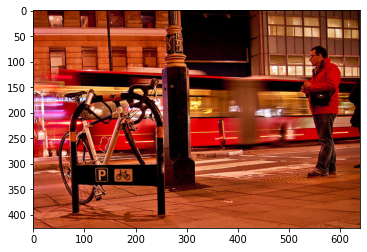

In [307]:
I = io.imread('/content/convert2Yolo/train2014/COCO_train2014_000000058143.jpg')
plt.figure()
plt.imshow(I)

I will now copy the images present in COCO text dataset from the original COCO dataset. 

In [296]:
val_filenames=[]
imgs = ct.loadImgs(valid_imgs)

for img in imgs:
  val_filenames.append(img['file_name'])

for x in Path('/content/valid2014').rglob('*.jpg'):
  if x.name in filenames:
    copyfile(x, '/content/drive/My Drive/coco-text-valid/'+x.name)

In [301]:
train_filenames=[]
imgs = ct.loadImgs(train_imgs)

for img in imgs:
  train_filenames.append(img['file_name'])

for x in Path('/content/train2014').rglob('*.jpg'):
  if x.name in filenames:
    copyfile(x, '/content/drive/My Drive/coco-text-train/'+x.name)

In [188]:
ct.loadImgs(train_imgs[np.random.randint(0,len(train_imgs))])[0]

{'file_name': 'COCO_train2014_000000107918.jpg',
 'height': 480,
 'id': 107918,
 'set': 'train',
 'width': 640}

## 2. Conversion

For object detection, COCO follows the following format:
```
annotation{
"id" : int,
"image_id": int,
"category_id": int,
"segmentation": RLE or [polygon],
"area": float,
"bbox": [x,y,width,height],
"iscrowd": 0 or 1,
}
categories[{
"id": int,
"name": str,
"supercategory": str,
}]
```

Whereas in YOLO, a .txt file with the same name is created for each image. Each .txt file contains the annotations for the corresponding image file, that is object class, object coordinates, height and width.
```
<object-class> <x> <y> <width> <height>
```
So, i'll have to write some code to make the annotations in YOLO format. 

In [ ]:
with open('/content/COCO_Text.json') as f:
  data = json.load(f)

In [ ]:
def convert(train_or_val):
  images = data['imgs']

  for x in tqdm(ct.loadAnns(train_or_val)):
    img = images[str(x['image_id'])]
    h, w, f = img['height'], img['width'], img['file_name']

    # The Labelbox bounding box format is [top left x, top left y, width, height]
    box = np.array(x['bbox'], dtype=np.float64)
    box[:2] += box[2:] / 2  # xy top-left corner to center
    box[[0, 2]] /= w  # normalize x
    box[[1, 3]] /= h  # normalize y

    if (box[2] > 0.) and (box[3] > 0.):  # if w > 0 and h > 0
      with open('/content/' train_or_val +'/' + f.split('.')[0] + '.txt', 'a') as file:
        file.write('0 '+' '.join([str(i) for i in box])+'\n')

In [141]:
convert(valid_anns)
convert(train_anns)

100%|██████████| 65720/65720 [00:04<00:00, 13529.72it/s]


## 3. YOLO v5 Trainig

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [3]:
!python train.py --img 640 --batch 16 --epochs 5 --data '/content/text.yaml' --cfg yolov5s.yaml --weights yolov5s.pt 

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='/content/text.yaml', device='', epochs=5, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-10-09 04:22:29.582695: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'o

In [4]:
!cp '/content/yolov5' -r '/content/drive/My Drive/First5'

In [5]:
!python train.py --img 640 --batch 16 --epochs 15 --data '/content/text.yaml' --cfg yolov5s.yaml --weights '/content/yolov5/runs/exp2/weights/best.pt'

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='/content/text.yaml', device='', epochs=15, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='/content/yolov5/runs/exp2/weights/best.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-10-09 06:09:46.531657: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'giou': 0.05, 'cls': 0.

In [6]:
!cp '/content/yolov5' -r '/content/drive/My Drive/YOLO'

In [19]:
!cp '/content/yolov5/inference/output/Times Square Vacation Travel Guide  Expedia.mp4' '/content/drive/My Drive'

## 4. Inference

In [17]:
YouTube('https://www.youtube.com/watch?v=sjnhnCsoUso').streams.first().download()

'/content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4'

In [18]:
!python detect.py --weights '/content/yolov5/runs/exp3/weights/best.pt' --img 416 --conf 0.4 --source '/content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4'

video 1/1 (3620/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.012s)
video 1/1 (3621/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.011s)
video 1/1 (3622/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.011s)
video 1/1 (3623/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.011s)
video 1/1 (3624/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.015s)
video 1/1 (3625/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.011s)
video 1/1 (3626/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts, Done. (0.014s)
video 1/1 (3627/3838) /content/yolov5/Times Square Vacation Travel Guide  Expedia.mp4: 288x416 3 machine texts,

In [42]:
!python '/content/drive/My Drive/YOLO/test.py' --weights '/content/drive/My Drive/YOLO/runs/exp3/weights/best.pt' --data '/content/text.yaml' --img 672

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/text.yaml', device='', img_size=672, iou_thres=0.65, merge=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/drive/My Drive/YOLO/runs/exp3/weights/best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... 
Model Summary: 191 layers, 7.25509e+06 parameters, 0 gradients
Scanning labels /content/drive/My Drive/labels/coco-text-valid.cache (3346 found, 0 missing, 0 empty, 2 duplicate, for 3346 images): 3346it [00:00, 19178.32it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 105/105 [13:01<00:00,  7.44s/it]
                 all    3.35e+03    1.51e+04        0.34       0.704        0.58       0.265
Speed: 3.5/0.9/4.4 ms inference/NMS/total per 672x672 image at batch-size 32


# 5. Export to ONNX

In [2]:
!python 'models/export.py' --weights '/content/drive/My Drive/YOLO/runs/exp3/weights/best.pt' --img 640 --batch 1  # export

Namespace(batch_size=1, img_size=[640, 640], weights='/content/drive/My Drive/YOLO/runs/exp3/weights/best.pt')
Fusing layers... 
Model Summary: 140 layers, 7.24652e+06 parameters, 0 gradients

Starting TorchScript export with torch 1.6.0+cu101...
/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1109: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(method_name, func, example_inputs, var_lookup_fn, strict, _force_outplace)
TorchScript export success, saved as /content/drive/My Drive/YOLO/runs/exp3/weights/best.torchscript.pt

Starting ONNX export with onnx 1.7.0...
